In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import time
import random

from sklearn.model_selection import train_test_split
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn import metrics as skm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
    
pd.options.display.max_columns = None

Using TensorFlow backend.


In [2]:
# decode labels for outcomes and pitch types

# outcome codes
outcome_code = {
    'outcome_code' : ['B', '*B', 'S', 'C',
                      'F', 'T', 'L', 'I',
                      'W', 'M', 'P',
                      'Q','R', 'X',
                      'D', 'E', 'H',
                      'V', 'Z'],
    'outcome_description' : ['Ball', 'Ball in Dirt', 'Swinging Strike', 'Called Strike',
                            'Foul', 'Foul Tip', 'Foul Bunt', 'Intentional Ball',
                            'Swinging Strike (Blocked)', 'Missed Bunt', 'Pitchout',
                            'Swinging Pitchout', 'Foul Pitchout', 'In Play, Out(s)',
                            'In Play, No Outs', 'In Play, Runs', 'Hit by pitch',
                            'V', 'Z']
}
outcome_code = pd.DataFrame.from_dict(outcome_code)

pitch_code = {
    'pitch_code': ['CH', 'CU', 'EP', 'FC',
                   'FF', 'FO', 'FS', 'FT',
                   'IN', 'KC', 'KN',
                   'PO', 'SC', 'SI',
                   'SL', 'UN', 'FA', 'AB'],
    'pitch_description': ['Changeup', 'Curveball', 'Eephus', 'Cutter',
                          'Four-seam Fastball', 'Pitchout', 'Splitter', 'Two-seam Fastball',
                          'Intentionall ball', 'Knuckle curve', 'Knuckleball',
                          'Pitchout', 'Screwball', 'Sinker',
                          'Slider', 'Unknown', 'FA', 'AB']
}
pitch_code = pd.DataFrame.from_dict(pitch_code)

In [3]:
# helper functions to load data and encode data
def load_data(num_rec=0):
    # load the data
    pitches = pd.read_csv("data/pitches.csv")
    atbats = pd.read_csv("data/atbats.csv")
    ejections = pd.read_csv("data/ejections.csv")
    games = pd.read_csv("data/games.csv")
    player_names = pd.read_csv("data/player_names.csv")

    # join all the data into all_df
    all_df = pd.merge(pitches, atbats, how='left',
            left_on = 'ab_id', right_on = 'ab_id')

    pitcher_df = player_names
    pitcher_df.columns = ['pitcher_id', 'pitcher_first_name', 'pitcher_last_name']

    all_df = pd.merge(all_df, pitcher_df, how='left',
            left_on = 'pitcher_id', right_on = 'pitcher_id')

    batter_df = player_names
    batter_df.columns = ['batter_id', 'batter_first_name', 'batter_last_name']

    all_df = pd.merge(all_df, batter_df, how='left',
            left_on = 'batter_id', right_on = 'batter_id')

    all_df = pd.merge(all_df, games, how='left',
            left_on = 'g_id', right_on = 'g_id')

    all_df = pd.merge(all_df, pitch_code, how='left',
            left_on = 'pitch_type', right_on = 'pitch_code')

    all_df = pd.merge(all_df, outcome_code, how='left',
            left_on = 'code', right_on = 'outcome_code')

    # extract weather conditions
    all_df['temp'] = all_df['weather'].str.extract(r'(\d+)')  # temperature
    all_df['temp'] = pd.to_numeric(all_df['temp'])
    all_df['weather_cond'] = all_df['weather'].str.extract(r'([^,]*$)')  # weather condition
    all_df['wind_mph'] = all_df['wind'].str.extract(r'(\d+)')  # wind speed
    all_df['wind_mph'] = pd.to_numeric(all_df['wind_mph'])
    all_df['wind_dir'] = all_df['wind'].str.extract(r'([^,]*$)')  # wind direction

    all_df.dropna(inplace=True)

    # specify subset of records to use
    if num_rec > 0:
        all_df = all_df[ :num_rec]
    return all_df

def encode_data(df_in, x_col_list, y_col, avail_cols, y_encode='none', factor=np.nan):
    col_no_encode = []
    # we know there's one dependent variable to seed a dataframe
    y_df = df_in[[y_col]]
    encode_df = y_df

    for col in x_col_list:
        if avail_cols.get(col):
            # one-hot encode
            dummies_df = pd.get_dummies(df_in[col], prefix=col)
            encode_df = pd.concat([encode_df, dummies_df], axis=1)
        else:
            # just retrieve the column directly
            col_no_encode.append(col)

    encode_df = encode_df.drop([y_col], axis=1) # remove dependent variable seeding column
    X = pd.concat([encode_df, df_in[col_no_encode]], axis=1)

    if y_encode=='factorize':
        # use factorized y value
        y_return = factor[0]
    elif y_encode=='onehot':
        # one hot encode y values
        y_return = pd.get_dummies(y_df, prefix=y_col)
    else:
        y_return = y_df

    y = y_return

    return X, y

In [4]:
# functions to evaluate the results of different models and write to file

def eval_rf(y_test_in, y_pred_in, classifier_in, factor_in, idx_in, vars_in, elapsed_time):
    f = open("rf_test_" + str(idx_in) + ".txt", "w")
    f.write(f'random forest test' + str(idx_in))
    print("\nElapsed time: %.1f [sec]" % (elapsed_time))
    f.write("\nElapsed time: %.1f [sec]" % (elapsed_time))
    # reverse factorization
    #reversefactor = dict(zip(range(18),factor_in))
    #y_test_rev = np.vectorize(reversefactor.get)(y_test_in)
    #y_pred = np.vectorize(reversefactor.get)(y_pred_in)

    # print confusion matrix
    # cm = pd.crosstab(y_test_rev, y_pred, rownames=['Actual Pitch'], colnames=['Predicted Pitch'])
    cm = pd.crosstab(y_test_in, y_pred_in, rownames=['Actual Pitch'], colnames=['Predicted Pitch'])

    f.write(f'\n')
    f.write(str(vars))

    f.write(f'\n')
    f.write(str(cm))
    print(cm)

    # print variable importance
    df_x_train = pd.DataFrame(X_train)

    feature_importances = pd.DataFrame(classifier_in.feature_importances_,
                                       index = df_x_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    train_col_df = pd.DataFrame(df_x_train.columns)
    fi = pd.merge(feature_importances, train_col_df, how='left',
            left_index = True, right_index = True)
    print(fi.iloc[:20])
    f.write(f'\n')
    f.write(str(fi.iloc[:20]))

    pscore = metrics.accuracy_score(y_test_in, y_pred_in)
    print(f'RF accuracy {pscore}')
    f.write(f'\n')
    f.write(f'\n')
    f.write(f'RF accuracy {pscore}')
    f.close()

def eval_nn(history_in, factor_in, idx_in, vars_in, elapsed_time_in):
    f = open("nn_test_" + str(idx_in) + ".txt", "w")
    f.write(f'neural net test ' + str(idx_in))
    print("\nElapsed time: %.1f [sec]" % (elapsed_time))
    f.write("\nElapsed time: %.1f [sec]" % (elapsed_time))
    # model architecture
    print(str(model.summary()))
    f.write(str(model.summary()))

    f.write(f'\n')
    f.write(str(vars))

    # accuracy/loss by epoch
    hist = pd.DataFrame(history_in.history)
    hist['epoch'] = history_in.epoch
    f.write('\n')
    f.write(str(hist))
    print(str(hist))

    # plot
    acc = history_in.history['accuracy']
    val_acc = history_in.history['val_accuracy']
    loss = history_in.history['loss']
    val_loss = history_in.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # exit accuracy and loss
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nExit test accuracy: {test_acc}')
    print(f'\nExit test loss: {test_loss}')
    f.write(f'\nExit test accuracy: {test_acc}')
    f.write(f'\nExit test loss: {test_loss}')

    f.close()

In [5]:
# These are the values one can pass in as variables
# Values specify whether the column should be one-hot encoded
# Some are known at the time of pitch and some are outcomes of a pitch
avail_cols = {
    'px': False,        'pz': False,        'start_speed': False,   'end_speed': False,
    'spin_rate': False, 'spin_dir': False,  'break_angle': False,   'break_length': False,
    'break_y': False,   'ax': False,        'ay': False,            'az': False,
    'sz_bot': False,    'sz_top': False,    'type_confidence': True,'vx0': False,
    'vy0': False,       'vz0': False,       'x': False,             'x0': False,
    'y': False,         'y0': False,        'z0': False,            'pfx_x': False,
    'pfx_z': False,     'nasty': False,     'zone': True,           'code':	True,
    'type': True,       'pitch_type': True, 'event_num': False,     'b_score': False,
    'ab_id' : True,     'b_count': True,    's_count': True,        'outs': True,
    'pitch_num': False, 'on_1b': False,     'on_2b': False,         'on_3b': False,
    'batter_id': True,  'event': True,      'g_id': True,           'inning': True,     'o': True,
    'p_score': False,   'p_throws': True,   'pitcher_id': True,     'stand': True,      'top': False,
    'pitcher_first_name': True,     'pitcher_last_name': True,      'batter_first_name': True,
    'batter_last_name': True,       'attendance': False,            'away_final_score': False,
    'away_team': True,  'date': True,       'elapsed_time': False,  'home_final_score': False,
    'home_team': True,  'start_time': False, 'umpire_1B': True,      'umpire_2B': True,
    'umpire_3B': True,  'umpire_HP': True,  'venue_name': True,     'weather': True,
    'wind': True,       'delay': False,     'pitch_code': True,     'pitch_description': True,
    'outcome_code': True,           'outcome_description': True,    'temp': False,
    'weather_cond': True,           'wind_mph': False,              'wind_dir': True
}

Load the data from the files 

In [6]:
# load data, calculate new columns, join data - optional number of records parameter
all_df = load_data(450000) # only able to get this many records processed without running out of memory
#all_df = load_data()

Data for baseline statistics

In [7]:
# pitch outcomes
outcome_df = all_df.groupby(['outcome_code', 'outcome_description']).size().reset_index(name='outcome_count')
outcome_df['outcome_prob']= outcome_df['outcome_count']/outcome_df['outcome_count'].sum()
outcome_df

,outcome_code,outcome_description,outcome_count,outcome_prob
0,*B,Ball in Dirt,9777,0.021727
1,B,Ball,148391,0.329758
2,C,Called Strike,76629,0.170287
3,D,"In Play, No Outs",19473,0.043273
4,E,"In Play, Runs",9799,0.021776
5,F,Foul,77703,0.172673
6,H,Hit by pitch,1041,0.002313
7,I,Intentional Ball,2074,0.004609
8,L,Foul Bunt,1613,0.003584
9,M,Missed Bunt,358,0.000796


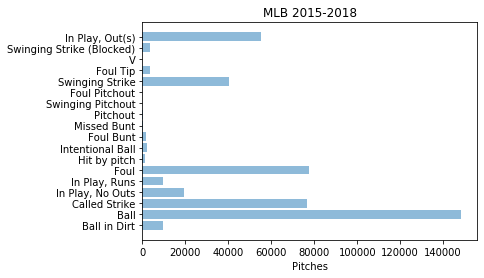

In [8]:
# bar chart of pitch outcomes
objects = outcome_df.outcome_description
y_pos = np.arange(len(outcome_df.outcome_description))
performance = outcome_df.outcome_count

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Pitches')
plt.title('MLB 2015-2018')

plt.show()

In [9]:
# pitch outcomes
pitch_df = all_df.groupby(['pitch_code', 'pitch_description']).size().reset_index(name='pitch_type_count')

pitch_df['pitch_prob']= pitch_df['pitch_type_count']/pitch_df['pitch_type_count'].sum()
pitch_df

,pitch_code,pitch_description,pitch_type_count,pitch_prob
0,AB,AB,1,0.000002
1,CH,Changeup,47551,0.105669
2,CU,Curveball,33058,0.073462
3,EP,Eephus,268,0.000596
4,FA,FA,9,0.000020
5,FC,Cutter,26272,0.058382
6,FF,Four-seam Fastball,158011,0.351136
7,FO,Pitchout,140,0.000311
8,FS,Splitter,7213,0.016029
9,FT,Two-seam Fastball,52360,0.116356


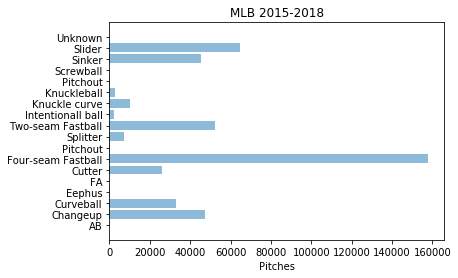

In [10]:
# bar chart of pitch types
objects = pitch_df.pitch_description
y_pos = np.arange(len(pitch_df.pitch_description))
performance = pitch_df.pitch_type_count

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Pitches')
plt.title('MLB 2015-2018')

plt.show()

In [11]:
# create one list of variables for each test you want to run
var_list = []

# here are all the variables that seem to be known before a pitch
# var_list.append(['b_score', 'b_count', 's_count','pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id', 'inning', 'o',
#                  'p_score', 'p_throws', 'stand', 'top', 'batter_id', 'pitcher_id',
#                  'away_team', 'home_team', 'umpire_HP','venue_name', 'weather', 'wind', 'delay'])

# if you want to pick x number of random predictors from all the options, uncomment these lines
# here are all the variables that seem to be known before a pitch
# var_list.append(['b_score', 'b_count', 's_count','pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id', 'inning', 'o',
#                  'p_score', 'p_throws', 'stand', 'top', 'batter_id', 'pitcher_id',
#                  'away_team', 'home_team', 'umpire_HP','venue_name', 'weather', 'wind', 'delay'])
# comb_list = list(combinations(var_list[0], 13))
# random.shuffle(comb_list)
# var_list = comb_list

# this seems to be the best so far with ~47.5% accuracy on an MLP
var_list.append(['b_count', 's_count', 'on_3b', 'p_score', 'p_throws', 'stand', 'pitcher_id', 'away_team'])


# factorize dependent variable - TODO: fix this so it works
factor = pd.factorize(all_df['pitch_code'])
pitch_code_def = factor[1]

Start of Multi-layer network (MLP)

Train on 360000 samples, validate on 90000 samples
Epoch 1/10
360000/360000 [==============================] - 18s 51us/step - loss: 1.2993 - accuracy: 0.4694 - val_loss: 1.3014 - val_accuracy: 0.4614
Epoch 2/10
360000/360000 [==============================] - 18s 51us/step - loss: 1.1905 - accuracy: 0.4918 - val_loss: 1.2838 - val_accuracy: 0.4605
Epoch 3/10
360000/360000 [==============================] - 18s 51us/step - loss: 1.1635 - accuracy: 0.4997 - val_loss: 1.2679 - val_accuracy: 0.4719
Epoch 4/10
360000/360000 [==============================] - 18s 51us/step - loss: 1.1483 - accuracy: 0.5047 - val_loss: 1.2673 - val_accuracy: 0.4730
Epoch 5/10
360000/360000 [==============================] - 18s 51us/step - loss: 1.1365 - accuracy: 0.5091 - val_loss: 1.2741 - val_accuracy: 0.4717
Epoch 6/10
360000/360000 [==============================] - 18s 51us/step - loss: 1.1277 - accuracy: 0.5116 - val_loss: 1.2735 - val_accuracy: 0.4709
Epoch 7/10
360000/360000 [=======================

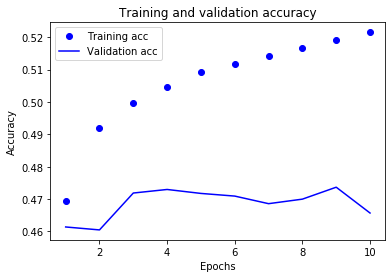


Exit test accuracy: 0.46567776799201965

Exit test loss: 1.2926988308270773


In [12]:
# loop through different combinations of predictors and run neural network calculations
for idx, vars in enumerate(var_list):
    # one-hot encode all necessary data and split into test/training data
    X, y = encode_data(all_df, x_col_list=vars, y_col='pitch_code', avail_cols=avail_cols,
                       y_encode='onehot', factor=factor)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

    #X_train = sklearn.preprocessing.maxabs_scale(X_train)
    #X_test = sklearn.preprocessing.maxabs_scale(X_test)

    X_train = sklearn.preprocessing.scale(X_train, copy=False)
    X_test = sklearn.preprocessing.scale(X_test, copy=False)

    t1_start = time.perf_counter()

    model = Sequential()
    model.add(Dense(512, input_dim=np.size(X_train,1), activation='relu'))
    model.add(Dense(256, input_dim=np.size(X_train,1), activation='relu'))
    model.add(Dense(np.size(y_train,1), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train,
                        y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(X_test, y_test),
                        verbose=True)

    t1_stop = time.perf_counter()
    elapsed_time = t1_stop - t1_start

    eval_nn(history, factor, idx, vars, elapsed_time)

Start of Random Forest calculations

In [13]:
#loop through different combinations of predictors and run random forest calculations
for idx, vars in enumerate(var_list):

    # one-hot encode all necessary data and split into test/training data
    X, y = encode_data(all_df, x_col_list=vars, y_col='pitch_code', avail_cols=avail_cols,
                       y_encode='factorize', factor=factor)
    #X = sklearn.preprocessing.scale(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
    print('after split')
    X_train = sklearn.preprocessing.scale(X_train, copy=False)
    print('after train scale')
    X_test = sklearn.preprocessing.scale(X_test, copy=False)
    print('after test scale')

    t1_start = time.perf_counter()

    # create and train random forest model
    classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42)
    classifier.fit(X_train, y_train)

    # predict test data
    y_pred = classifier.predict(X_test)

    t1_stop = time.perf_counter()
    elapsed_time = t1_stop - t1_start

    # print metrics for random forest model
    eval_rf(y_test, y_pred, classifier, factor, idx, vars, elapsed_time)


after split
after train scale
after test scale

Elapsed time: 271.6 [sec]
Predicted Pitch     0    1     2     3     4     5   6     7    8   9    10  \
Actual Pitch                                                                  
0                22154  925   859   863  1524  1752  56  2832  412   0  322   
1                 3764  983   331   437   415   482   2   538    0   0   61   
2                 2193  221  1358   432   342   286  14   300   79   1  113   
3                 2023  183   212  4847   518    24  20   760  166   2   82   
4                 4860  217   255   969  1488   766  17   533  128   0    2   
5                 4868  343   236     9   599  2767  32   923   60   0  122   
6                  235    4     6    27    16    32  36    17    0   0    2   
7                 6516  259   258  1008   413   833   8  3494   40   0  104   
8                  785    0   135   281    92   102   0    77  478   0    0   
9                   10    2     0     6     3     5   0  